In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

use_google_colab = False

if use_google_colab==True:
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_project = '/content/drive/MyDrive/School/1. University/Year 4/Semester 2/APS360 - Applied Fundamentals of Deep Learning/Project/'
else:
    # When using on local machine. Folder 'split_data' must be in the same dir as this file.
    path_to_project=""
    
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0

    for images, _ in loader:
        images_count = images.size(0)
        images = images.view(images_count, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += images_count

    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [25]:
def get_test_data_loader_with_normalization(batch_size, img_dim, path_to_project, device):
    """
    Returns a DataLoader for the test dataset with normalization but without augmentation.

    Args:
        batch_size: The number of samples per batch to load.
        img_dim: Size to resize the incoming images. E.g., AlexNet takes 224x224 images.
        path_to_project: Path to the project folder containing the 'split_data' folder.
        device: The device to use for the DataLoader. Either 'cuda' or 'cpu'.

    Returns:
        test_loader: DataLoader for the test set.
    """
    # Initial Transforms without normalization to calculate mean and std
    initial_transform = transforms.Compose([
        transforms.Resize((img_dim, img_dim)),
        transforms.ToTensor(),
    ])
    
    # Load the training data without any augmentation to calculate the mean and std
    train_dataset = datasets.ImageFolder(os.path.join(path_to_project, 'split_data/train'), transform=initial_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=device == 'cuda')

    # Calculate mean and std
    mean, std = calculate_mean_std(train_loader)
    
    # Transform for test data with normalization but without augmentation
    transform_with_normalization = transforms.Compose([
        transforms.Resize((img_dim, img_dim)),
        transforms.ToTensor(),
        transforms.Normalize(mean.tolist(), std.tolist()),
    ])

    # Load test dataset with normalization
    test_dataset = datasets.ImageFolder(os.path.join(path_to_project, 'split_data/test'), transform=transform_with_normalization)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=device == 'cuda')

    return test_loader

In [26]:
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ModifiedAlexNet, self).__init__()
        # Using the original AlexNet configuration with modifications
        self.features = nn.Sequential(
            # Convolutional Layer #1: Input (227x227x3) -> Output (55x55x96)
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True), # Inplace operation to reduce memory usage
            nn.MaxPool2d(kernel_size=3, stride=2), # Input (55x55x96) -> Output (27x27x96)
            
            # Convolutional Layer #2: Input (55x55x96) -> Output (27x27x256)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Convolutional Layer #3: Input (27x27x256) -> Output (6x6x384)
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # Adaptive Average Pooling Layer: Input (6x6x384) -> Output (6x6x384)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        # FCs
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(384 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


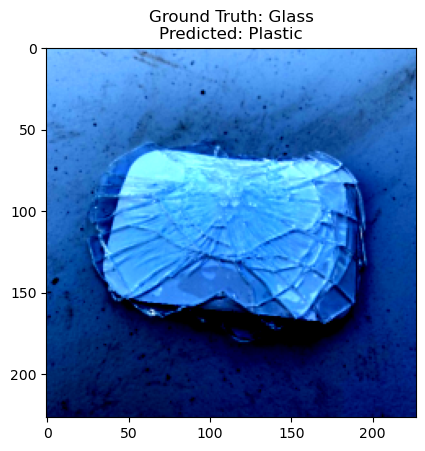

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


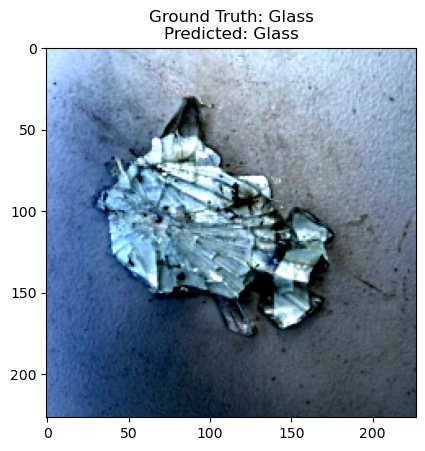

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


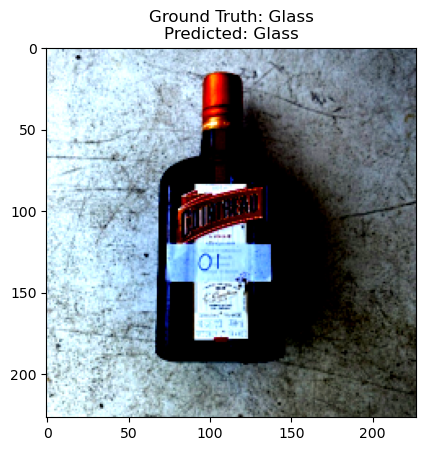

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


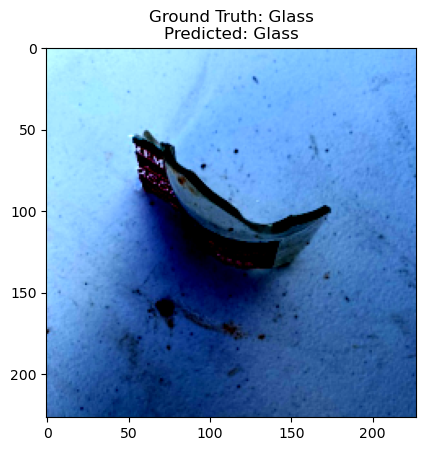

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


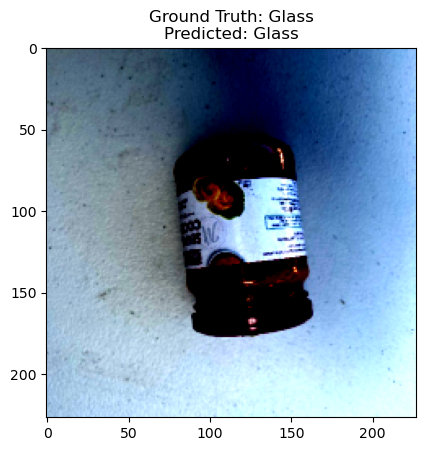

In [27]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def imshow_individual(img, label, prediction):
    """
    Displays a single image with its ground truth and predicted label.

    Args:
        img: The image tensor.
        label: The ground truth label (as an index).
        prediction: The predicted label (as an index).
    """
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f'Ground Truth: {class_labels[label]}\nPredicted: {class_labels[prediction]}')
    plt.show()

best_model_path = os.path.join(path_to_project, "ModifiedAlexNet_lr=0.0001_epochs=80_batch=128/model_ModifiedAlexNet_lr=0.0001_epochs=80_batch=128.pth")
test_loader = get_test_data_loader_with_normalization(batch_size=128, img_dim=227, path_to_project=path_to_project, device=device)

model = ModifiedAlexNet().to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Class labels
class_labels = ['Glass', 'Metal', 'Paper', 'Plastic']

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Predict
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Display a few test images with predictions
for i in range(len(images)):
    imshow_individual(images[i], labels[i].item(), predicted[i].item())

    # Optional: break after displaying a certain number of images
    if i == 4:  # Adjust the number of images you want to display
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


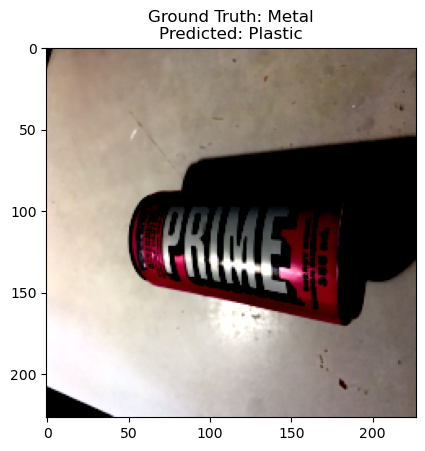

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


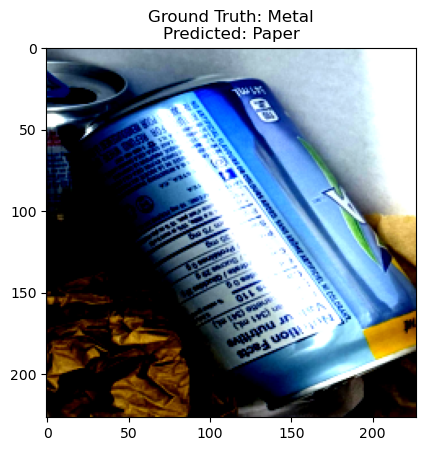

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


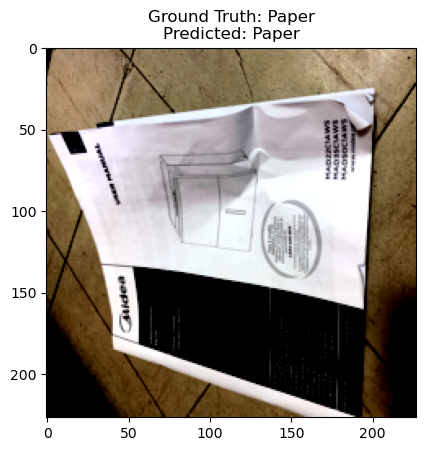

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


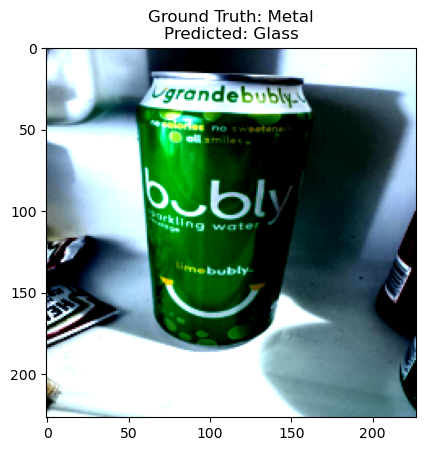

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


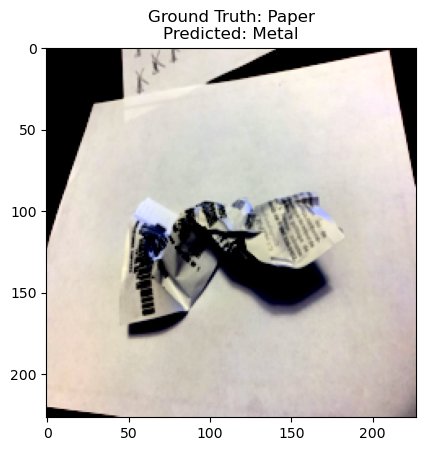

In [28]:
import random
from PIL import Image

# Path to the unseen_data folder
path_to_unseen_data = os.path.join(path_to_project, 'unseen_data')

initial_transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
    ])

# Load the training data without any augmentation to calculate the mean and std
unseen_dataset = datasets.ImageFolder(root=path_to_unseen_data, transform=initial_transform)
data_loader_unseen = DataLoader(unseen_dataset, batch_size=32, shuffle=True, num_workers=1)

# Calculate mean and std
mean, std = calculate_mean_std(data_loader_unseen)

# Define the transform with normalization for unseen data
transform_unseen = transforms.Compose([
    transforms.Resize((227, 227)),  # Adjust the size as per your CNN input
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Create the dataset and data loader for unseen data
unseen_dataset = datasets.ImageFolder(root=path_to_unseen_data, transform=transform_unseen)
data_loader_unseen = DataLoader(unseen_dataset, batch_size=32, shuffle=True, num_workers=1)

# Get a batch of test images
dataiter = iter(data_loader_unseen)
images, labels = next(dataiter)

# Predict
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Display a few test images with predictions
for i in range(len(images)):
    imshow_individual(images[i], labels[i].item(), predicted[i].item())

    # Optional: break after displaying a certain number of images
    if i == 4:  # Adjust the number of images you want to display
        break